# LAB | Ensemble Methods

**Load the data**

In this challenge, we will be working with the same Spaceship Titanic data, like the previous Lab. The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

In this Lab, you should try different ensemble methods in order to see if can obtain a better model than before. In order to do a fair comparison, you should perform the same feature scaling, engineering applied in previous Lab.

In [133]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [135]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [137]:
#your code here

spaceship = spaceship.dropna()
spaceship['Cabin']= spaceship['Cabin'].str[0]
spaceship= spaceship.drop(['PassengerId','Name'], axis=1)

In [140]:
spaceship_cat= spaceship.select_dtypes(include=['object'])
spaceship_cat= pd.get_dummies(spaceship_cat, dtype = int)
spaceship_num = spaceship.select_dtypes(include=['number'])

In [142]:
spaceship_combined = pd.concat([spaceship_num, spaceship_cat], axis=1)
spaceship_combined

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,0,0,1,...,0,0,1,0,0,0,0,1,1,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0
4,16.0,303.0,70.0,151.0,565.0,2.0,1,0,0,1,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
8689,18.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,0,1,0,0,1,0,1,0
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1,0,0,1,...,0,0,0,1,0,0,0,1,1,0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


**Perform Train Test Split**

In [145]:
#your code here

features = spaceship_combined
target = spaceship["Transported"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

In [147]:
#normalize 

from sklearn.preprocessing import MinMaxScaler, StandardScaler
normalizer = MinMaxScaler()

In [149]:
normalizer.fit(X_train)  

MinMaxScaler()

In [151]:
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)

**Model Selection** - now you will try to apply different ensemble methods in order to get a better model

- Bagging and Pasting

In [155]:
#your code here  LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [157]:
lr = LogisticRegression()
lr.fit(X_train_norm, y_train)

LogisticRegression()

In [159]:
y_pred_lr = lr.predict(X_test_norm)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [161]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_lr

0.7700453857791225

- DECISION TREE
  

In [164]:
#your code here DECISION TREE depth= 2: 0.72, 50: 0.75 , 30: 0.75, 8: 0.77

from sklearn.tree import DecisionTreeClassifier, plot_tree

In [166]:
dt = DecisionTreeClassifier(random_state=0, max_depth=7)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=0)

In [168]:
y_pred_dt= dt.predict(X_test)

In [170]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_dt

0.7677760968229954

<class 'pandas.core.frame.DataFrame'>


[Text(0.4379222972972973, 0.9375, 'x[9] <= 0.5\ngini = 0.5\nsamples = 5284\nvalue = [2618, 2666]'),
 Text(0.15498310810810811, 0.8125, 'x[6] <= 0.5\ngini = 0.302\nsamples = 1865\nvalue = [345, 1520]'),
 Text(0.05912162162162162, 0.6875, 'x[15] <= 0.5\ngini = 0.091\nsamples = 986\nvalue = [47, 939]'),
 Text(0.02702702702702703, 0.5625, 'x[0] <= 2.5\ngini = 0.02\nsamples = 881\nvalue = [9, 872]'),
 Text(0.013513513513513514, 0.4375, 'x[7] <= 0.5\ngini = 0.211\nsamples = 25\nvalue = [3, 22]'),
 Text(0.006756756756756757, 0.3125, 'gini = 0.0\nsamples = 22\nvalue = [0, 22]'),
 Text(0.02027027027027027, 0.3125, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.04054054054054054, 0.4375, 'x[0] <= 35.5\ngini = 0.014\nsamples = 856\nvalue = [6, 850]'),
 Text(0.033783783783783786, 0.3125, 'x[0] <= 34.5\ngini = 0.021\nsamples = 560\nvalue = [6, 554]'),
 Text(0.02027027027027027, 0.1875, 'x[11] <= 0.5\ngini = 0.011\nsamples = 535\nvalue = [3.0, 532.0]'),
 Text(0.013513513513513514, 0.0625, 'gini

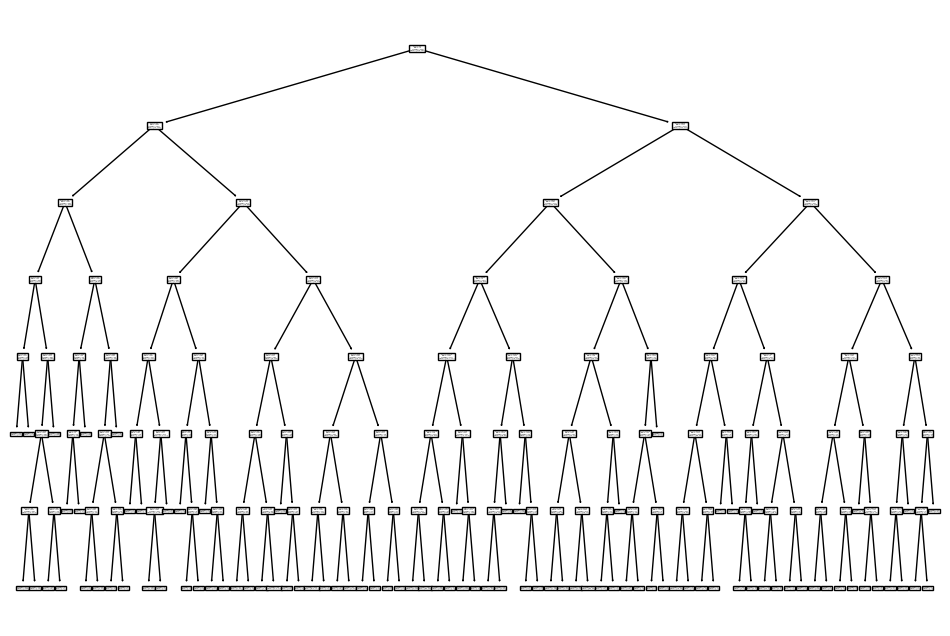

In [172]:
print(type(X_test))
plt.figure(figsize=(12, 8))
plot_tree(dt)

- Random Forest

In [180]:
from sklearn.ensemble import RandomForestClassifier

In [182]:
rf= RandomForestClassifier(n_estimators=8, random_state=0, max_depth=7)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=8, random_state=0)

In [184]:
y_pred_rf= rf.predict(X_test)

In [185]:
accuracy_rf= accuracy_score(y_test, y_pred_rf)
accuracy_rf

0.7783661119515886

- Gradient Boosting

In [193]:
#your code here: gradient boosting predicts errors made by predecessor 

gb_cl = GradientBoostingClassifier(max_depth=20,
                                   n_estimators=100)

In [203]:
gb_cl.fit(X_train_norm, y_train)

GradientBoostingClassifier(max_depth=20)

In [ ]:
y_pred_gbc = gb_cl.predict(X_test_norm)

In [243]:
cm = confusion_matrix(y_test, y_pred_gbc)

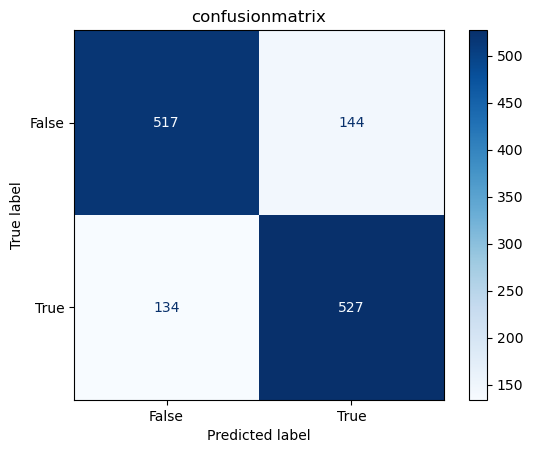

In [265]:
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_cl.classes_)
disp1.plot(cmap='Blues')
plt.title('confusionmatrix')
plt.show()

In [221]:
accuracy_gbc= accuracy_score(y_test, y_pred_gbc)
accuracy_gbc

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


0.789712556732224

- Adaptive Boosting

In [255]:
#your code here: sequentially focuses on difficult-to-classify-instances

ada_cl = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                            n_estimators=100)

In [257]:
ada_cl.fit(X_train_norm, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   n_estimators=100)

In [258]:
y_pred_abc = ada_cl.predict(X_test_norm)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


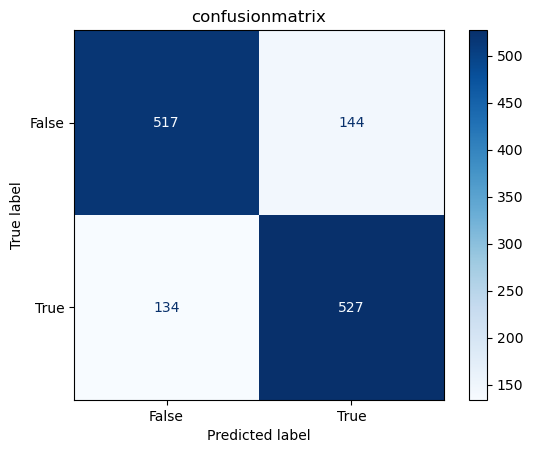

In [267]:
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ada_cl.classes_)
disp2.plot(cmap='Blues')
plt.title('confusionmatrix')
plt.show()

In [263]:
accuracy_abc = accuracy_score(y_test, y_pred_abc)
accuracy_abc

0.7708018154311649

Which model is the best and why?

In [37]:
#comment here: best accuracy: random forest gradient booster